<a href="https://colab.research.google.com/github/AmirMoazzami/207_final_project/blob/main/Zillow_streamlined_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W207 Final Project: Zillow Prize: Zillow’s Home Value Prediction

* Gray Selby
* Amir Moazami
* Soroush Yazdani

<font color='red'> As extensive data cleaning was necessary, we have prepared a separate notebook named "Zillow_feature_selection_at_length.ipynb." In this notebook, you'll find the lengthy process of investigating each feature individual to determine how to handle various data types and imputation as half of the overall data is missing from the data set. Also view utilities.py for the ZillowClass and acompanying functions that were used to handle the data. With these suplimental works mentioned, this notebook will provide the narrative. </font>

In this competition, Zillow has requested participants to predict the log-error between their Zestimate and the actual sale price of homes, using all available features. The log error is calculated as the logarithm of the Zestimate minus by the logarithm of the SalePrice:

**logerror = log(Zestimate) - log(SalePrice)**

We are provided a dataset containing real estate properties from three counties in California: Los Angeles, Orange, and Ventura, for parts of 2016 and 2017.

Using the provided data, our objective is to make predictions for six specific time points across all properties: October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).

### This notebook will progress as follows:
 - Load the data
 - Train, vaidation, test split
 - Baselines
 - Evaluation of the targets
 - Data engineering (handling missing data and data types)
 - Feature importance (ExtraTrees)
 - ML models (hyperparameter search)
    - Lasso
    - Random Forest Regressor
    - XGBoost
    - k-Nearest Neighbors
    - Dense Neural Network 
 - Modling results
 - Test Results (XGBoost)
 - Competition score
 - Conclusion 

In [33]:
# Import the libraries we'll use below.
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew #for some statistics

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings('ignore')

In [34]:
# set numpy random dseed
np.random.seed(42)

This file contains the class ZillowData. We will instantiate an instance of this class below to help us manage the data. Look at utilities.py for more details.

In [35]:
# Import our utilities.py file
import importlib
import utilities
importlib.reload(utilities)
from utilities import *

The data was saved and shared on a google drive so everyone have access to them.

In [36]:
from google.colab import drive
drive.mount('/content/drive')


ModuleNotFoundError: No module named 'google.colab'

In [73]:
# Instantiate ZillowData object with the path to the directory housing the data provided by Kaggle
folder_path = r"/content/drive/MyDrive/W207_Zillow/zillow-prize-1/"
ZD = ZillowData(folder_path)

# Load the Data

In [38]:
# loading the data using the utitilities.py library
ZD.get_data()
ZD.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167888 entries, 0 to 167887
Data columns (total 60 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   parcelid                      167888 non-null  int64  
 1   logerror                      167888 non-null  float64
 2   transactiondate               167888 non-null  object 
 3   airconditioningtypeid         53788 non-null   float64
 4   architecturalstyletypeid      468 non-null     float64
 5   basementsqft                  93 non-null      float64
 6   bathroomcnt                   167854 non-null  float64
 7   bedroomcnt                    167854 non-null  float64
 8   buildingclasstypeid           31 non-null      float64
 9   buildingqualitytypeid         107173 non-null  float64
 10  calculatedbathnbr             166056 non-null  float64
 11  decktypeid                    1272 non-null    float64
 12  finishedfloor1squarefeet      12893 non-null

There were numerous ParcelIDs that they were repeated many time. The houses didn't sell and they showed up again in the market again. Only the last transaction data is selected leavning 167,888 rows with an associated logerror target value.

Note that many feature columns are missing data and there are multiple data types in the initial dataset.

### Check for duplicate entries

We need to ensure that there are no duplicate rows with the same parcelID and transaction date. Thankfully this is not an issue as shown below.

In [39]:
ZD.check_for_duplicates()

Number of duplicates IDs: 0 / 167888


# Train-Validation-Test Split

Before we start to explore the data we will conduct the train, validation, test split. This is done to avoid bias that we may introduce by observing the validation and test sets as well as to ensure that data is kept seperate to evaluate the models we will train fairly. 

We will randomly select 70% of the data for the train set, leaving 15% for validation and 15% for test. We will explore the train set to investigate the logerror target values and to determine what features we will use and how to handle missing data. We will then apply the transformations determined from the train set on the validation and test sets. Models will be trained on the train set and evaluated with the validation set for hyperparameter tuning. Finally, the best model will be applied to the test set. Then that model will submit predictions for the Kaggle competition.

In [40]:
ZD.train_val_test_split(train_prob=0.7)

Train set ratio: 0.70


Validation set ratio: 0.15
Test set ratio: 0.15


# Baseline Targets

Our baseline metrics will be:
 - Mean Absolute Error (MAE) 
 - Mean Squared Error (MSE) 
 
We will compare the performance of our models using these metrics. First, we must determine baseline measurements using these metrics. The following section discusses the logerror target values of the train set. In the case of this data set and competition, the logerror values are distributed about zero in a guassian-like distribution. 

We can calculate the MAE and MSE of the logerror values of our train set for our baseline measurements. The idea here is that the least skillful approach one could take would be to simply measure the distribution of the logerror values in the train set and randomly guess logerror values given this distribution. These measurements of the logerror values provide a rough indication of metrics which we expect any skillful model (a model that is actually learning a generalization of the data) to surpase. As we will see later in the notebook, we do indeed succeed in surpasing these baselines. The aim will be for our models to achieve MAE and MSE smaller than these values.

In [41]:
# Mean absolute error
print(f'Mean Absolute Error: {ZD.train.logerror.mad():.5}')

Mean Absolute Error: 0.069714


In [42]:
# Mean squared error
print(f'Mean Squared Error: {ZD.train.logerror.std():.5}')


Mean Squared Error: 0.16536


## Evaluation of the logerror Target Values

We will investigate the distribution of the logerror target values in the train set.

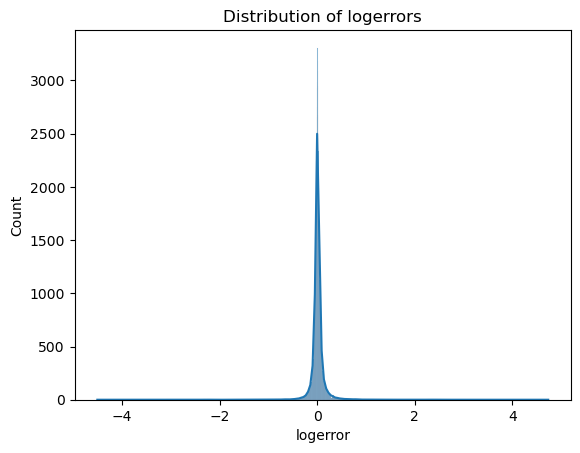

In [43]:
ZD.plot_logerr_hist(df=ZD.train)

Now, let's plot the Q-Q plot for an measure of how normally distributed the values are.

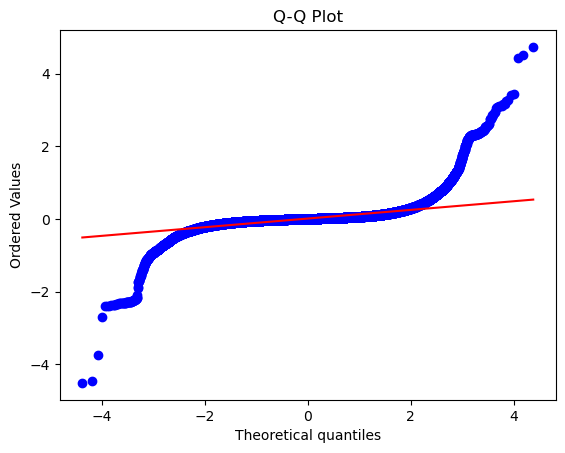

In [44]:
ZD.plot_logerr_QQ(df=ZD.train)

This unique data set and challenge provides regression targets that are somewhat normally destributed but for the presence of some outliers. Instead of trying to predict outliers in the data, we will remove these outliers from the train set in an effort to allow the models to better learn the majority of cases.

We remove rows corresponding to logerror outliers that are more than 3 standard deviations from the mean.

In [45]:
def remove_outliers(data_df, n_stds=3):
    len_df = data_df.shape[0]
    high_thresh = data_df.logerror.mean() + n_stds * data_df.logerror.std()
    low_thresh = data_df.logerror.mean() - n_stds * data_df.logerror.std()
    trimmed_df = data_df[data_df.logerror < high_thresh]
    trimmed_df = trimmed_df[data_df.logerror > low_thresh]

    len_trimmed = trimmed_df.shape[0]
    print(f'{len_df - len_trimmed} of {len_df} outliers removed.')

    return trimmed_df

In [46]:
trimmed_train = remove_outliers(ZD.train, n_stds=3)

1746 of 117521 outliers removed.


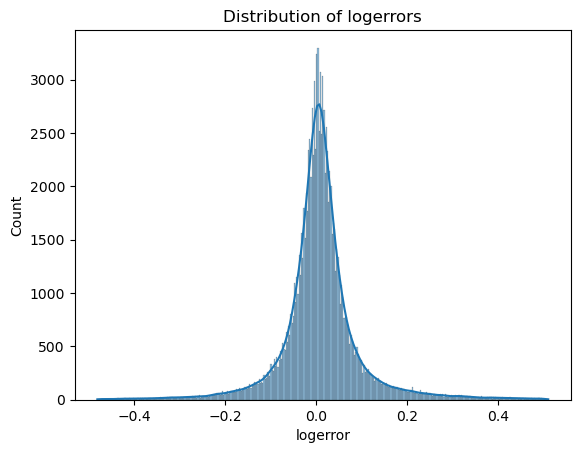

In [47]:
ZD.plot_logerr_hist(df=trimmed_train)

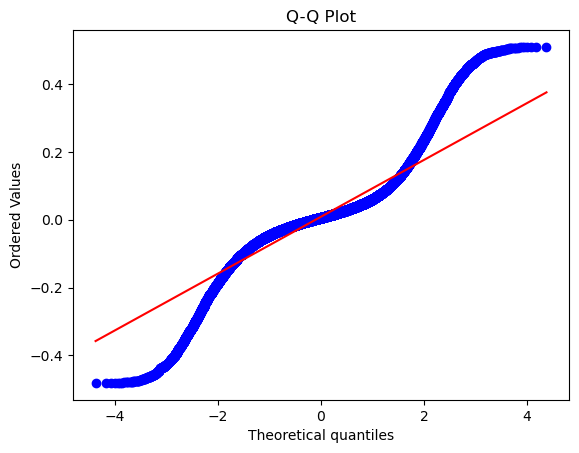

In [48]:
ZD.plot_logerr_QQ(df=trimmed_train)

Now we update the train set after the outliers were removed. We do not touch the validation or test sets as that would not allow us to evaluate how well our models are generalizing. The point of removing extreme outliers from the train set is to allow our models to focus on learning the general trend instead of trying to accomodate outlier cases.

In [49]:
ZD.train = trimmed_train

Next form the datasets by separating the X data from the Y targets.

In [50]:
ZD.form_datasets()

In [51]:
print(f'Train X shapes:      {ZD.train_x.shape}, Y shapes: {ZD.train_y.shape}')
print(f'Validation X shapes: {ZD.val_x.shape},  Y shapes: {ZD.val_y.shape}')
print(f'Test X shapes:       {ZD.test_x.shape},  Y shapes: {ZD.test_y.shape}')

Train X shapes:      (115775, 59), Y shapes: (115775, 1)
Validation X shapes: (25184, 59),  Y shapes: (25184, 1)
Test X shapes:       (25183, 59),  Y shapes: (25183, 1)


# Data Engineering

### Missing data, imputation, feature selection

We will now investigate the feature data. As shown below, on average, nearly half of a given feature column rows are missing. Additionally, various feature columns are of different data types. We must investigate each feature column, decide whether or not to select the feature for modeling, impute the missing values and convert to float data type. 

This analysis will provide valuable insights into the interdependencies among the variables and aid in our subsequent modeling and decision-making processes.


<font color='red'> For an indepth view of how each feature column was individually handled, please view the notebook "Zillow_feature_selection_at_length.ipynb". This notebook will keep this section concise and will leverage the function call 'ZD.clean_all_data()' in the file utilities.py. </font>


In [52]:
train_na_ratio_df = ZillowData.get_missing_ratio_df(ZD.train_x)

Unfortunately nearly half of the data is missing.

In [53]:
print(f'Average percent of missing data per column: {train_na_ratio_df.NAN_ratio.mean()*100:.1f}%')

Average percent of missing data per column: 47.6%


Each column's missing data ratio is shown below.

In [54]:
train_na_ratio_df

,NAN_ratio
buildingclasstypeid,0.999845
finishedsquarefeet13,0.999594
storytypeid,0.999447
basementsqft,0.999447
yardbuildingsqft26,0.998955
fireplaceflag,0.997659
architecturalstyletypeid,0.997132
typeconstructiontypeid,0.996804
finishedsquarefeet6,0.995483
decktypeid,0.992477


## Handling of missing data


As stated above, this notebook will keep this section concise by leveraging the below call to the ZillowData class. For a full walkthrough see the notebook: Zillow_feature_selection_at_length.ipynb.

This process includes:
 - dropping columns:
    - if missing data is excessive and there is not logical argument to impute the values 
 - impute zero:
    - investigating the distribution of certain values reveals that many can logically be argued that missing values should be zeros to indicate that a certain characteristic about a given property was simply not present
 - impute mode:
    - some columns without too much missing data can be reasonably imputed with the mode of the distribution and when the value is descrete
 - impute median:
    - other columns with nice normal-like distributions of continuous values can be imputed with the median (assuming not too much of the data is missing)

In [55]:
ZD.clean_all_data()

Now we will ensure that all remaining columns (which are now imputed) are of type float32.

In [56]:
ZD.convert_column_type(col_type=np.float32)

In [57]:
print(f'Train X shapes:      {ZD.train_x.shape}, Y shapes: {ZD.train_y.shape}')
print(f'Validation X shapes: {ZD.val_x.shape},  Y shapes: {ZD.val_y.shape}')
print(f'Test X shapes:       {ZD.test_x.shape},  Y shapes: {ZD.test_y.shape}')

Train X shapes:      (115775, 37), Y shapes: (115775, 1)
Validation X shapes: (25184, 37),  Y shapes: (25184, 1)
Test X shapes:       (25183, 37),  Y shapes: (25183, 1)


In [58]:
ZD.train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115775 entries, 81426 to 13739
Data columns (total 37 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   airconditioningtypeid         115775 non-null  float32
 1   bathroomcnt                   115775 non-null  float32
 2   bedroomcnt                    115775 non-null  float32
 3   buildingqualitytypeid         115775 non-null  float32
 4   decktypeid                    115775 non-null  float32
 5   calculatedfinishedsquarefeet  115775 non-null  float32
 6   finishedsquarefeet12          115775 non-null  float32
 7   fips                          115775 non-null  float32
 8   fireplacecnt                  115775 non-null  float32
 9   garagecarcnt                  115775 non-null  float32
 10  garagetotalsqft               115775 non-null  float32
 11  hashottuborspa                115775 non-null  float32
 12  heatingorsystemtypeid         115775 non-

Now, let's try to find the correlation between each of the parameters. This provides an indication of how similar some features are to one another.

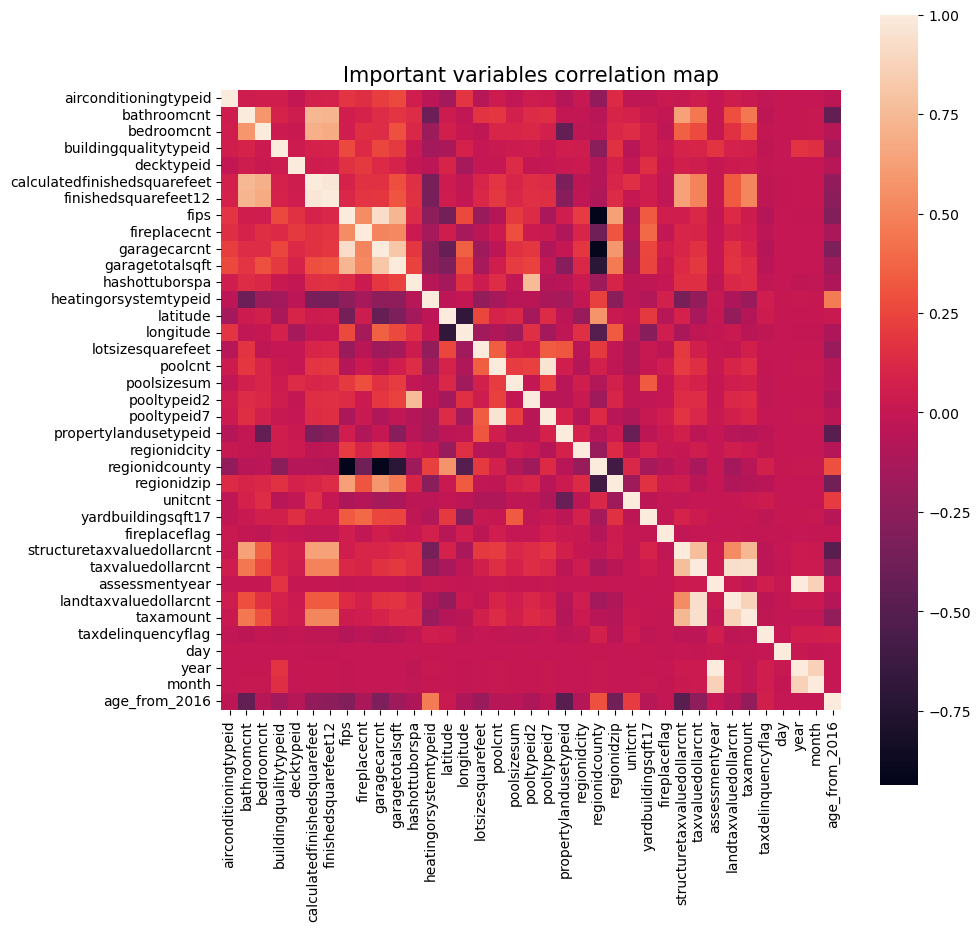

In [59]:
corrmat = ZD.train_x.corr(method='spearman')

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

From the correlation map, we can see the following highly correlated columns:
 - Group 1: 
    - calculatedfinishedsquarefeet
    - finishedsquarefeet12
 - Group 2: 
    - poolcnt
    - pooltypeid7
 - Group 3: 
    - structuretaxvaluedollarcnt
    - taxvaluedollarcnt
    - landtaxvaluedollarcnt
    - taxdeliquencyflag
 - Group 4: 
    - assessmentyear
    - year
    - month

While we identify these similar features, we decide not to drop them from the data sets. Although the correlation plot shows that they are correlated with each other, that does not strictly mean that each is not independently relevant to the logerror values that we are trying to predict. 

Now, let's see where the data sits Geographically. The Kaggle website mentioned that the data is coming from the LA, Orange and Ventura counties. So let's plot the data based on the longitude and latitude:

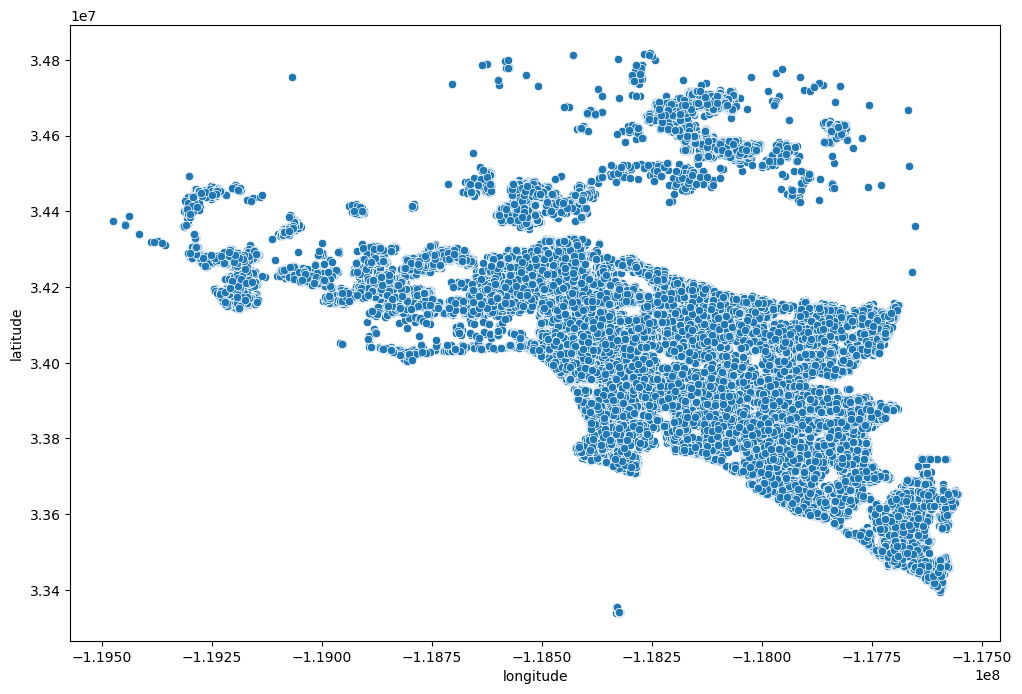

In [60]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='longitude',y='latitude',data=ZD.train_x)
plt.show()

That pretty much very similar to google map picture. The border between the ocean and the land is clearly show in the above data. One note that needs to be consider is that most of the outliers are the expensive houses that are closest to the water. These houses usually have a high logerror values.

Google Maps: 

![](https://drive.google.com/uc?export=view&id=1ffaNzw2p8MJWOg3lHRQ98reoL1AlB4Oe)

# Feature Importance (ExtraTrees)

In [ ]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(ZD.train_x, ZD.train_y)

ExtraTreesRegressor(max_depth=30, max_features=0.3, n_estimators=25, n_jobs=-1,
                    random_state=0)

In [ ]:
## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

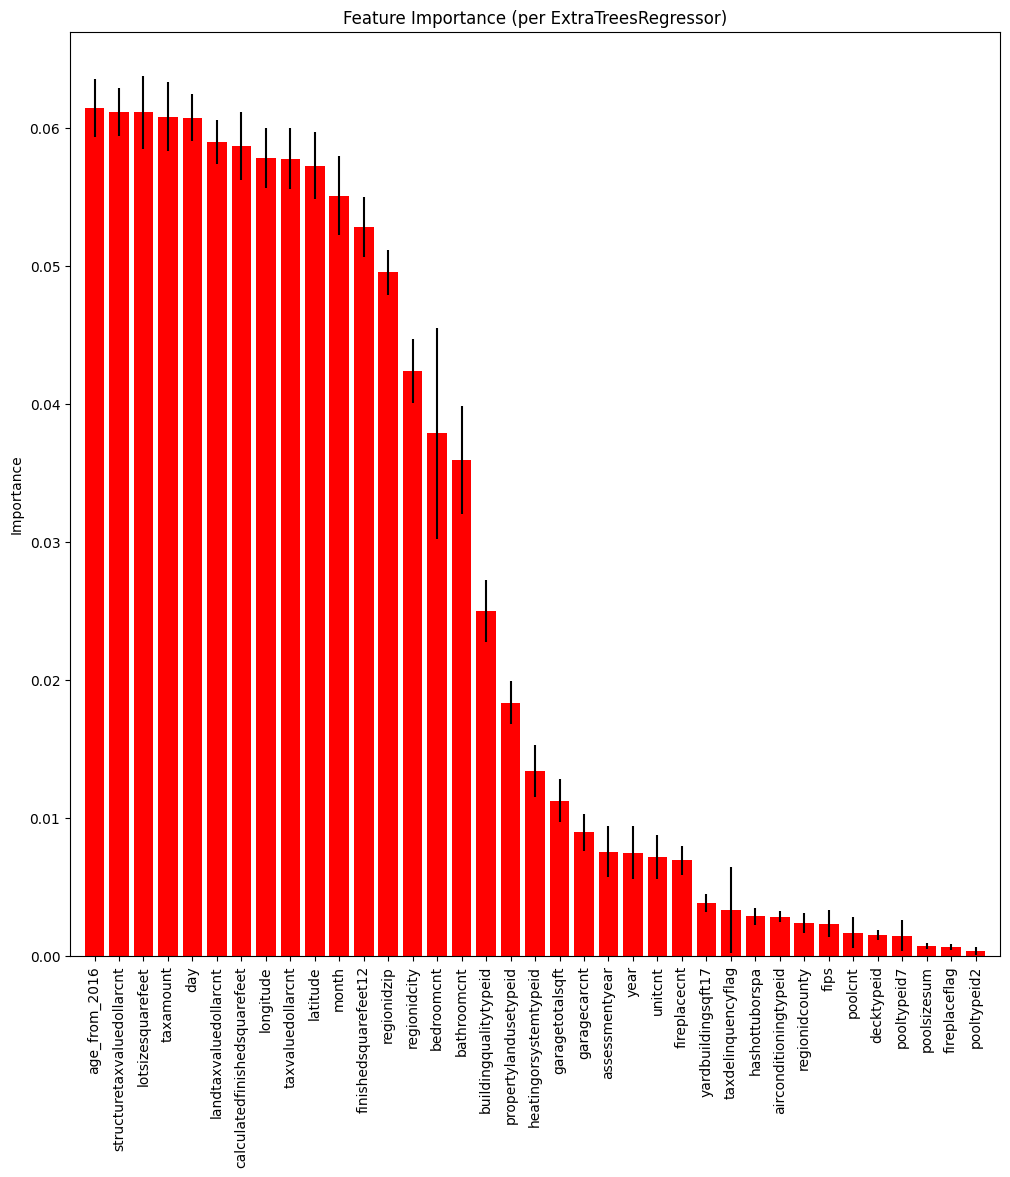

In [ ]:
plt.figure(figsize=(12,12))
plt.title("Feature Importance (per ExtraTreesRegressor)")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), ZD.train_x.columns.values[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.ylabel('Importance')
plt.show()

It is insteresting to see that the ExtraTreesRegressor lists the following as all about equivalently the most important features.
 - age_from_2016
 - structuretaxvalueddollarcnt
 - lotsizesquarefeet
 - taxamount
 - day

Looking at this ranking of features, it seems reasonable that the following characteristics are important to consider within the context of predicting logerrors
 - age of the property
 - tax amounts
 - size of the property
 - timing of the sale
 - location of the property

In [61]:
# importing sklearn libraries
from sklearn.preprocessing import StandardScaler , RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split , cross_val_predict , RandomizedSearchCV
from sklearn.linear_model import Ridge , Lasso , ElasticNet
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor , ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
#from xgboost import XGBRegressor
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn import linear_model

In [62]:
#minmaxscalar = MinMaxScaler()
standardscalar = StandardScaler()

In [63]:
ZD.train_x_normalized = standardscalar.fit_transform(ZD.train_x)
ZD.val_x_normalized = standardscalar.transform(ZD.val_x)
ZD.test_x_normalized = standardscalar.transform(ZD.test_x)

# ML Models

This section will discuss model training and hyperparameter search. We use grid hyperparameter search to find the best hyperparameters for each model. GridSearchCV (Grid Search Cross-Validation) is a technique used to systematically search for the best combination of hyperparameters for a machine learning model. It's a common method for hyperparameter tuning, especially when we have a limited number of hyperparameters to tune and we want to explore all possible combinations of these hyperparameters. We used this for Lasso, Random Forest, XGBoost and KNN, Nueral Network models.

In below section, you will see the work for each ML model.

## Lasso

The Lasso regression model is a linear regression technique that includes L1 regularization, which encourages sparsity in the model coefficients. This can be useful for feature selection and handling multicollinearity.

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# Define the parameter grid for GridSearchCV
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
}

# Create the Lasso model
lasso_model = Lasso()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Fit the grid search to your data
grid_search.fit(ZD.train_x_normalized, ZD.train_y)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the best model for prediction
y_pred = best_model.predict(ZD.val_x_normalized)

# Evaluate the model's performance
mse = mean_squared_error(ZD.val_y, y_pred)
mae = mean_absolute_error(ZD.val_y, y_pred)
print("Best Hyperparameters:", best_params)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Best Hyperparameters: {'alpha': 0.001}
Mean Squared Error: 0.024392506049123013
Mean Absolute Error: 0.0665652569630056


The alpha parameter controls the strength of the regularization. A smaller alpha encourages stronger regularization and can lead to more coefficients being set to zero. 

The grid search determined that an alpha value of 0.001 yielded the best results.

Note that the the MSE and MAE were each smaller than the baseline measurements previously discussed.
Baselines:
 - MSE: 0.16536
 - MAE: 0.069714

Lasso metrics:
 - MSE: 0.02439
 - MAE: 0.06656

We see that the MSE is greatly improved. This might be explained by there being less dramticly wrong estimates, which the second order nature of MSE will penalize more heavily than MAE. MAE is also improved upon but less dramatically. These observations will remain true for the rest of the models we evaluate.

Now let's plot our prediction and validation results to see how far they are from each other.

Text(0.5, 1.0, 'Prediction vs Validaion plot')

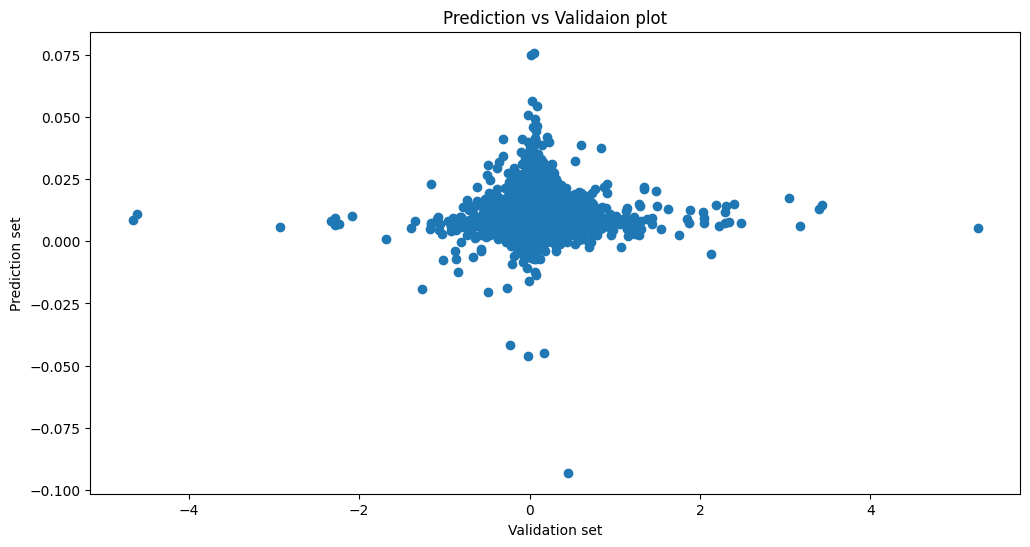

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(ZD.val_y, y_pred)
plt.xlabel('Test set')
plt.ylabel('Prediction set')
plt.title('Prediction vs Test plot')

As it shown above most of the data are located near zero which means the logerror between prediction and test data set is close to each other which shows the model found a good agreement between prediction and test set.

## Random Forest Regressor

A Random Forest Regressor is an ensemble model for regression tasks. It combines multiple decision trees trained on random subsets of data to make accurate predictions. It's valuable because it reduces overfitting, handles complex relationships, provides feature importance, is robust, and is relatively easy to use.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [30, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Create the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Fit the grid search to your data
grid_search.fit(ZD.train_x_normalized, ZD.train_y)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the best model for prediction
y_pred = best_model.predict(ZD.val_x_normalized)

# Evaluate the model's performance
mse = mean_squared_error(ZD.val_y, y_pred)
mae = mean_absolute_error(ZD.val_y, y_pred)
print("Best Hyperparameters:", best_params)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Mean Squared Error: 0.02423483574630849
Mean Absolute Error: 0.06644136658314007


The grid search determined that the following parameters yielded the best results:
 - max depth: 10
 - min samles split: 10
 - n estimators: 100

Note that the the MSE and MAE were each smaller than the baseline measurements previously discussed.
Baselines:
 - MSE: 0.16536
 - MAE: 0.069714

Random Forest metrics:
 - MSE: 0.02423
 - MAE: 0.06644

Text(0.5, 1.0, 'Prediction vs Validaion plot')

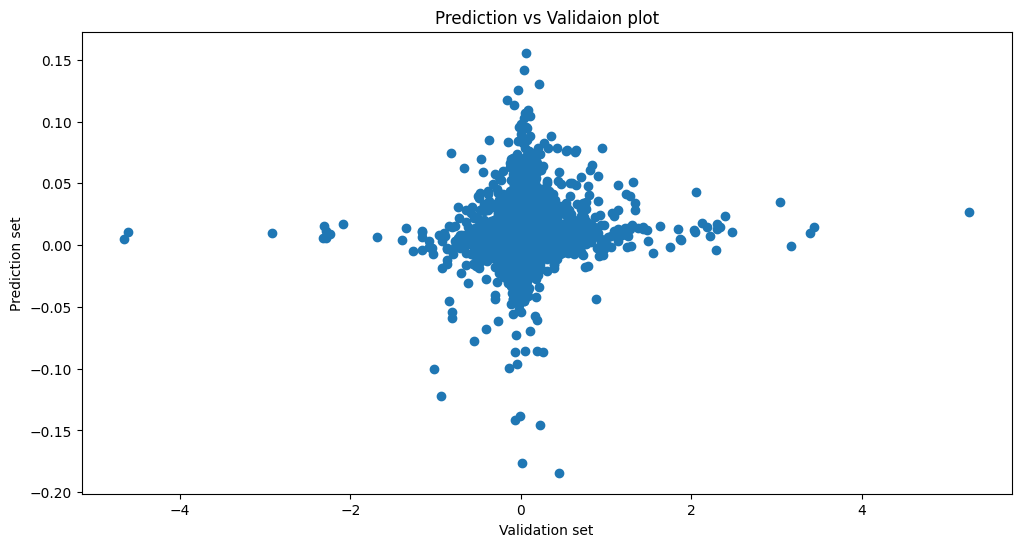

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(ZD.val_y, y_pred)
plt.xlabel('Test set')
plt.ylabel('Prediction set')
plt.title('Prediction vs Test plot')

## XGBoost

XGBoost (Extreme Gradient Boosting) is a powerful machine learning algorithm that's popular for both classification and regression tasks. It's a boosting algorithm, which means it builds a strong predictive model by combining the predictions of multiple weaker models (usually decision trees) in a sequential manner.

In [30]:
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Create the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Fit the grid search to your data
grid_search.fit(ZD.train_x_normalized, ZD.train_y)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the best model for prediction
y_pred = best_model.predict(ZD.val_x_normalized)

# Evaluate the model's performance
mse = mean_squared_error(ZD.val_y, y_pred)
mae = mean_absolute_error(ZD.val_y, y_pred)
print("Best Hyperparameters:", best_params)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Mean Squared Error: 0.024234096118360235
Mean Absolute Error: 0.06636125183802036


The grid search determined that the following parameters yielded the best results:
 - learning rate: 0.1
 - max depth: 3
 - n estimators: 200
 - subsample: 1.0

Note that the the MSE and MAE were each smaller than the baseline measurements previously discussed.
Baselines:
 - MSE: 0.16536
 - MAE: 0.069714

XGBoost metrics:
 - MSE: 0.02423
 - MAE: 0.06636

XGBoost appears to yield the best results with the lowest MSE and MAE measurements.

Text(0.5, 1.0, 'Prediction vs Validaion plot')

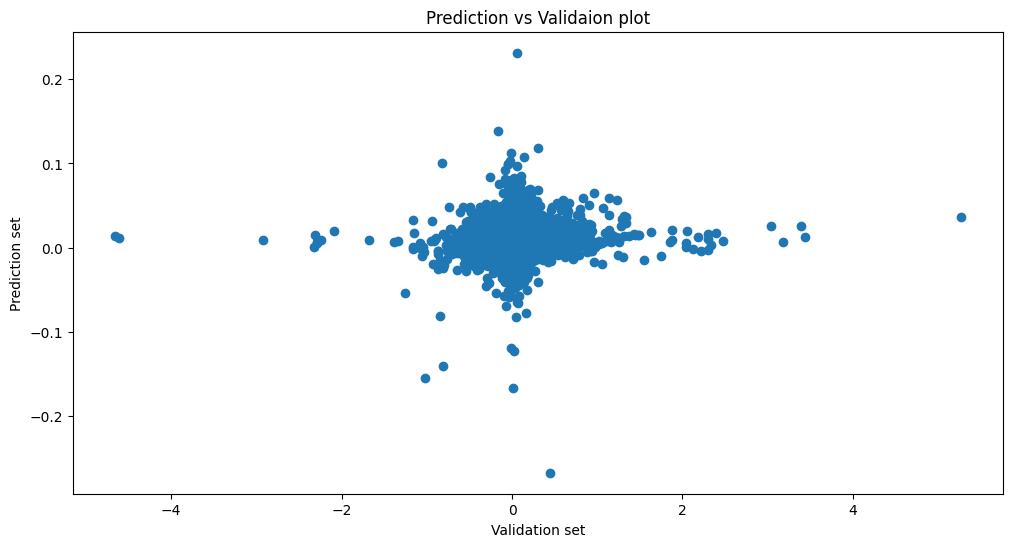

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(ZD.val_y, y_pred)
plt.xlabel('Test set')
plt.ylabel('Prediction set')
plt.title('Prediction vs Test plot')

## kNN

Let's do the exact thing for the KNN. This method is famous enough so we didn't bring its definition here :)


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# Create the KNN model
knn_model = KNeighborsRegressor()

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9]
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Fit the grid search to your data
grid_search.fit(ZD.train_x_normalized, ZD.train_y)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the best model for prediction
y_pred = best_model.predict(ZD.val_x_normalized)

# Evaluate the model's performance
mse = mean_squared_error(ZD.val_y, y_pred)
mae = mean_absolute_error(ZD.val_y, y_pred)
print("Best Hyperparameters:", best_params)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Best Hyperparameters: {'n_neighbors': 9}
Mean Squared Error: 0.0249971451284804
Mean Absolute Error: 0.07143900255417508


The grid search determined that the following parameters yielded the best results:
 - number of neighbors: 9

Note that the the MSE and MAE were each smaller than the baseline measurements previously discussed.
Baselines:
 - MSE: 0.16536
 - MAE: 0.069714

kNN metrics:
 - MSE: 0.02500
 - MAE: 0.07144

Text(0.5, 1.0, 'Prediction vs Validaion plot')

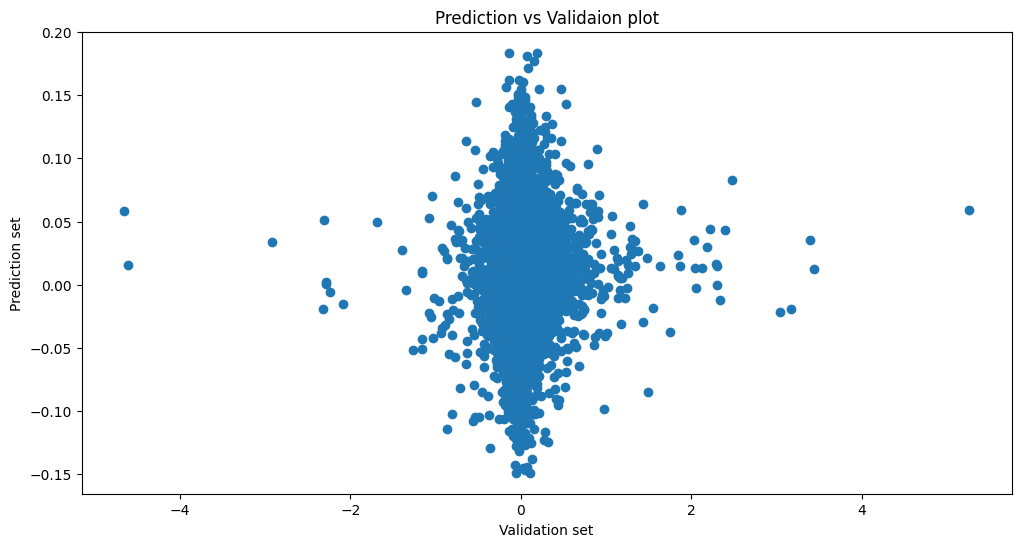

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(ZD.val_y, y_pred)
plt.xlabel('Validation set')
plt.ylabel('Prediction set')
plt.title('Prediction vs Test plot')

## Neural Network

For Neural Network the gridsearch method was also used. The selected hyperparameters to optimzed were: batch_size, learning_rate, neurons_layer1,neurons_layer2, dropout_rate, regularization_rate. Since, the running these were taking so long. We commented out the original section and provide the best results in the next code cell.

In [ ]:
#Last version with the grid search
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

def create_model(learning_rate=0.001, neurons_layer1=64, neurons_layer2=32, dropout_rate=0.3, regularization_rate=0.01):
    model = Sequential()

    model.add(Dense(neurons_layer1, input_shape=(ZD.train_x_normalized.shape[1],), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_rate)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(neurons_layer2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_rate)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    return model

model = KerasRegressor(build_fn=create_model, epochs=20)

param_grid = {
    'batch_size': [256, 512],
    'learning_rate': [0.001, 0.0005],
    'neurons_layer1': [64, 128],
    'neurons_layer2': [32, 64],
    'dropout_rate': [ 0.2, 0.3],
    'regularization_rate': [0.01, 0.001]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result = grid.fit(ZD.train_x_normalized, ZD.train_y)

print("Best parameters:", grid_result.best_params_)

The grid search determined that the following parameters yielded the best results:
 - batch_size: 512
 - dropout_rate: 0.2
 - learning_rate: 0.001
 - neurons_layer1: 128
 - neurons_layer2: 32
 - regularization_rate: 0.001

So we are using the above results just to run the NN once and create the plots.

In [ ]:
#Last version with the grid search
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

def create_model(learning_rate=0.001, neurons_layer1=64, neurons_layer2=32, dropout_rate=0.3, regularization_rate=0.01):
    model = Sequential()

    model.add(Dense(neurons_layer1, input_shape=(ZD.train_x_normalized.shape[1],), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_rate)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(neurons_layer2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_rate)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    return model

model = KerasRegressor(build_fn=create_model, epochs=20)

param_grid = {
    'batch_size': [512],
    'learning_rate': [0.001],
    'neurons_layer1': [128],
    'neurons_layer2': [32],
    'dropout_rate': [ 0.2],
    'regularization_rate': [0.001]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result = grid.fit(ZD.train_x_normalized, ZD.train_y)

print("Best parameters:", grid_result.best_params_)

Epoch 1/20
151/151 [==============================] - 3s 6ms/step - loss: 0.1725
Epoch 2/20
151/151 [==============================] - 1s 5ms/step - loss: 0.0922
Epoch 3/20
151/151 [==============================] - 1s 4ms/step - loss: 0.0728
Epoch 4/20
151/151 [==============================] - 1s 4ms/step - loss: 0.0586
Epoch 5/20
151/151 [==============================] - 1s 5ms/step - loss: 0.0480
Epoch 6/20
151/151 [==============================] - 1s 5ms/step - loss: 0.0395
Epoch 7/20
151/151 [==============================] - 1s 5ms/step - loss: 0.0332
Epoch 8/20
151/151 [==============================] - 1s 4ms/step - loss: 0.0284
Epoch 9/20
151/151 [==============================] - 1s 4ms/step - loss: 0.0245
Epoch 10/20
151/151 [==============================] - 1s 6ms/step - loss: 0.0216
Epoch 11/20
151/151 [==============================] - 1s 7ms/step - loss: 0.0193
Epoch 12/20
151/151 [==============================] - 1s 7ms/step - loss: 0.0173
Epoch 13/20
151/151 [====

In [ ]:
best_model = grid_result.best_estimator_.model
predictions = best_model.predict(ZD.val_x_normalized)

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(ZD.val_y, predictions)
mae = mean_absolute_error(ZD.val_y, predictions)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

787/787 [==============================] - 1s 1ms/step
Mean Squared Error: 0.024435376259417142
Mean Absolute Error: 0.0665953296757014


The grid search determined that the following parameters yielded the best results:
 - batch_size: 512
 - dropout_rate: 0.2
 - learning_rate: 0.001
 - neurons_layer1: 128
 - neurons_layer2: 32
 - regularization_rate: 0.001

Note that the the MSE and MAE were each smaller than the baseline measurements previously discussed.
Baselines:
 - MSE: 0.16536
 - MAE: 0.069714

NN metrics:
 - MSE: 0.02443
 - MAE: 0.06659

answer is:
787/787 [==============================] - 1s 1ms/step
Mean Squared Error: 0.029026304043712543
Mean Absolute Error: 0.06849104287466867

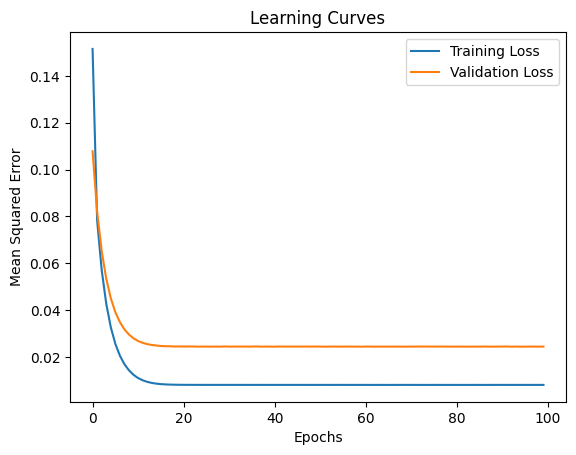

In [ ]:
#best model ploting
best_params = grid_result.best_params_


batch_size = best_params.pop('batch_size')


best_model = create_model(**best_params)


history = best_model.fit(
    ZD.train_x_normalized, ZD.train_y,
    epochs=100,
    validation_data=(ZD.val_x_normalized, ZD.val_y),
    batch_size=batch_size,
    verbose=0
)

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

The above plot begs the question of if the model is overfitting. On the one hand, the training loss is much smaller than the validation loss. This alone may be grounds to consider this mode overfitting. On the other hand, the validation loss is not increasing as might be expected of a model that is overfitting and increasingly struggling to generalize to the validation set. Both the train and validation losses plateau after about 18 epochs. One might choose to evaluate the parameters from this point, or after additional epochs. 

The validation MSE and MAE metrics are not as low as they are for Random Forest and XGBoost so we will not apply the test set to the NN.

# Modeling Results
So let's put a chart for all of the model that we have been tried so far and see what we got after applying the validation set.

| Model name | MSE |  MAE | Hyperparameters selection
|:-:                |:-:                  |:-:           |:-:       |
|**Baseline**              | 0.165                 | 0.0697           | -
| **Lasso**              | 0.0249                | 0.0666       | learning rate   
| **Random Forest**      | 0.0242                | 0.0669   | n_estimators, max_depth, min_samples_split
| **XGBoost**            | 0.0242                | 0.0663   | n_estimators, max_depth, learning_rate, subsample
| **KNN**                | 0.0250                |  0.714   |  n_neighbors
| **NN**                | 0.0244                | 0.0666    | batch_size, learning_rate, neurons_layers, dropout_rate, regularization_rate

The overall performance of the models surpassed that of the baseline, indicating substantial improvement. Notably, among the models employed, Random Forest and XGBoost demonstrated superior predictive capabilities for the test data.

### Evaluate the test set (XGBoost)

Now that we have identified the best overall model as XGBoost considering both MSE and MAE from the validation set, we will apply the test set that has been held in reserve until now.

In [65]:
# Create and fit the Random Forest regression model
xgb_model = xgb.XGBRegressor(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=200,
    subsample=1.0,
    random_state=42,
)

# Fit the grid search to your data
xgb_model.fit(ZD.train_x_normalized, ZD.train_y)

# Use the best model for prediction
y_pred = xgb_model.predict(ZD.test_x_normalized)

# Evaluate the model's performance
mse = mean_squared_error(ZD.test_y, y_pred)
mae = mean_absolute_error(ZD.test_y, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 0.030816339295010473
Mean Absolute Error: 0.06935048732675747


It appears that both MSE and MAE for the test set are worse than those calculated for the validation set. Both improve on the baseline measurements we took of the train logerror. 

# Competition Score


### Original Winners of Zillow Competition

First, let's see who took the million dollar home! The winners for this competition and their story can be found in the link below:


[link to the Winners website](https://www.zillow.com/z/info/zillow-prize/#:~:text=Meet%20the%20Zillow%20Prize%20Champions,time%20zones%20foil%20their%20efforts.)


Using the provided data, our objective is to make predictions for six specific time points across all properties: October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).

We decided to participate in the challenge and see how our models works among the others. We picked XGBoost as our best model and submit the results to the Kaggle. After submitting we got 0.0758 private score. This put us around 2000th rank among 3770 participants.

![](https://drive.google.com/uc?export=view&id=17KeBV-IBjySx5hdj1ff-CdgHZ7Y0z-dT)



Load in the sample submission file and the properties_2016 file as directed by Kaggle.

In [67]:
# load in sample submission
sample_submission = pd.read_csv(os.path.join(folder_path, "sample_submission.csv"))
sample_submission['parcelid'] = sample_submission['ParcelId']
sample_submission.head()

,ParcelId,201610,201611,201612,201710,201711,201712,parcelid
0,10754147,0,0,0,0,0,0,10754147
1,10759547,0,0,0,0,0,0,10759547
2,10843547,0,0,0,0,0,0,10843547
3,10859147,0,0,0,0,0,0,10859147
4,10879947,0,0,0,0,0,0,10879947
...,...,...,...,...,...,...,...,...
2985212,168176230,0,0,0,0,0,0,168176230
2985213,14273630,0,0,0,0,0,0,14273630
2985214,168040630,0,0,0,0,0,0,168040630
2985215,168040830,0,0,0,0,0,0,168040830


In [68]:
housing_info_2016 = pd.read_csv(os.path.join(folder_path, "properties_2016.csv"))
housing_info_2016.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985212,168176230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985213,14273630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985214,168040630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985215,168040830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


merge on 'parcelid' to get the final evaluation data

In [69]:
df_test = pd.merge(sample_submission[['parcelid']], housing_info_2016, on='parcelid', how='left')

Fit the XGBoost model on the train data.

In [70]:
# Create and fit the Random Forest regression model
xgb_model = xgb.XGBRegressor(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=200,
    subsample=1.0,
    random_state=42,
)
xgb_model.fit(ZD.train_x_normalized, ZD.train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

For each of the dates to evaluate, provide the correct date information and make the predictions for that timestamp.

In [72]:

test_dates = {
    '201610': pd.Timestamp('2016-09-30'),
    '201611': pd.Timestamp('2016-10-31'),
    '201612': pd.Timestamp('2016-11-30'),
    '201710': pd.Timestamp('2017-09-30'),
    '201711': pd.Timestamp('2017-10-31'),
    '201712': pd.Timestamp('2017-11-30')
}

submission = pd.DataFrame({'ParcelId': df_test['parcelid']})

for label, test_date in test_dates.items():
    print(f'Predicting for {label}')
    temp_df_test = pd.merge(sample_submission[['parcelid']], housing_info_2016, on='parcelid', how='left')
    # update date information
    temp_df_test['transactiondate'] = test_date
    # clean the dataset
    temp_df_test_cleaned = ZD.clean_df(temp_df_test)
    # standardize the dataset
    temp_df_test_cleaned_normed = standardscalar.fit_transform(temp_df_test_cleaned)
    
    # Make predictions on the test set
    y_pred = xgb_model.predict(temp_df_test_cleaned_normed)
    
    # add predictions to output file
    submission[label] = y_pred
    
submission.head()

Predicting for 201610
Predicting for 201611
Predicting for 201612
Predicting for 201710
Predicting for 201711
Predicting for 201712


,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,-0.019907,-0.019907,-0.019907,-0.019907,-0.019907,-0.019907
1,10759547,-0.016976,-0.016976,-0.016976,-0.016976,-0.016976,-0.016976
2,10843547,-0.007346,-0.007346,-0.007346,-0.007346,-0.007346,-0.007346
3,10859147,0.006895,0.006895,0.006895,0.006895,0.006895,0.006895
4,10879947,-0.004803,-0.004803,-0.004803,-0.004803,-0.004803,-0.004803
...,...,...,...,...,...,...,...
2985212,168176230,0.009715,0.009715,0.009715,0.009715,0.009715,0.009715
2985213,14273630,0.009715,0.009715,0.009715,0.009715,0.009715,0.009715
2985214,168040630,0.009715,0.009715,0.009715,0.009715,0.009715,0.009715
2985215,168040830,0.009715,0.009715,0.009715,0.009715,0.009715,0.009715


Note that although we are updating the transaction date for each prediction timestamp, the predictions themselves are not necessarily changing. Looking at other teams submissions shared on Kaggle, many other teams did not even bother to update the transaction date and just provided the same predictions per row regarldess of the transaction date being considered.

In [ ]:
# function to save the submission dataframe as a csv file given a file path and name
def save_submission(df, save_path, submission_file_name):
    df.to_csv(os.path.join(save_path, submission_file_name))
    
save_submission(submission, save_path='', submission_file_name='')

# Conclusion
This project aimed to predict the logerror between the Zestimate and the actual sale prices of houses using various machine learning models. The data was split into train, validation and test sets at the start of our work. Then the train set was investigated to better understand the data. This revealed the need to handle missing data which required dropping some features and imputing others with either zeros, the mode or the median. Subsequently, a range of ML models, including Lasso, Random Forest, XGBoost, KNN, and Neural Network, were employed to predict the test data. Additionally, a grid search method was applied to identify optimal hyperparameters for each model, ensuring the best possible solutions.

### Future Work
Future work might focus on:
 - evaluating various subsets of feature columns and data engineering:
    - an emperical study (not dissimilar to the grid searches we perform) might study the impact of different subsets of feature columns and various ways of handling the missing values
    - additionally, we could inform these subselections using:
        - correlation (remove highly correlated feature columns)
        - ExtraTrees feature importance 
 - devise an intuitive way to understand the relationship between the logerror values and the dollar amounts that the Zestimate was off by. It would be valuable if the model could express its price estimates in specific dollar amounts, enhancing interpretability and usability.